In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectKBest,  chi2
from sklearn import tree
from sklearn.metrics import  roc_curve, roc_auc_score,accuracy_score, precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score

from numpy import loadtxt
from sklearn.model_selection import train_test_split,GridSearchCV 
import matplotlib.pyplot as plt

from sklearn.utils import class_weight

import shap
shap.initjs()

In [2]:
X = pd.read_csv('../data/Training_Data/Training_Dataset.csv')

repackaged_benign_test_X =  pd.read_csv('../data/Test_Data/Repackaged_Benign_Testset.csv')
covid_test_X = pd.read_csv('../data/Test_Data/COVID_Testset.csv')
y = pd.read_csv('../data/Training_Data/Labels.csv')
repackaged_benign_test_y = pd.read_csv('../data/Test_Data/Labels_Repackaged_Benign_Test.csv')
COVID_test_y = pd.read_csv('../data/Test_Data/Labels_COVID_Test.csv')

In [4]:
X['label']=y['label']

In [8]:
X.groupby('label').count()

,Package_Name,SHA256,ThumbPrint,Application_Category,Family_Name,Malware_Category,Malware/Benign,Permission: FACTORY_TEST,Permission: DUMP,Permission: BATTERY_STATS,...,pressure,proximity,relative_humidity,rotation_vector,significant_motion,stationary_detect,step_counter,step_detector,temperature,if_the_app_using_suspicious_libs
label,,,,,,,,,,,,,,,,,,,,,
0,2004,2004,2004,894,0,0,2004,2004,2004,2004,...,2004,2004,2004,2004,2004,2004,2004,2004,2004,2004
1,9142,9142,9142,1543,0,0,9142,9142,9142,9142,...,9142,9142,9142,9142,9142,9142,9142,9142,9142,9142


In [6]:
2004+repackaged_benign_test_y.shape[0]

4862

In [3]:
# Delete useless features told by Shirish
drop_lst=['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign','sdkVersion', 'targetSdkVersion','if_the_app_using_suspicious_libs']
X.drop(drop_lst, axis = 1, inplace = True)

repackaged_benign_test_X.drop(drop_lst, axis = 1, inplace = True)
drop_lst.remove('if_the_app_using_suspicious_libs')
covid_test_X.drop(drop_lst, axis = 1, inplace = True)


## Feature Exploration

#### Remove features with 0 variance

In [4]:
drop_features = X.max()[X.max() == 0].index.to_list()
X.drop(drop_features, axis = 1, inplace = True)
repackaged_benign_test_X.drop(drop_features, axis = 1, inplace = True)
covid_test_X.drop(drop_features, axis = 1, inplace = True)

In [5]:
# Check if there's no onehot feature has missing values
X.describe().loc['count'][X.describe().loc['count'] < 10954]

Series([], Name: count, dtype: float64)

## Feature Summary:


### Original Dataset:

#### (1) Missing Values:
   + Features with 100% missing values: 'sdkVersion', 'targetSdkVersion' (deleted)


#### (2) Features with 0 Variance:
  + Number of Features with 0 Variance: 511 (deleted)


### Preprocessed Dataset:

#### (1) Categories of Features:
  + Number of one-hot features: 352
 
 
#### (2) Features Extracted by Us
  + Number of featuers extracted by us (sensors): 29

## Correlation Between Features and Target

In [6]:
chi_2, p = chi2(X, y)

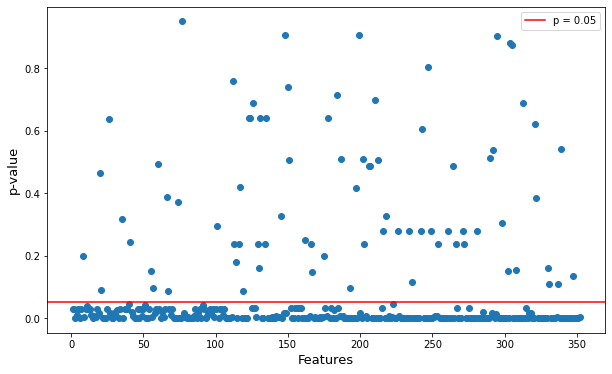

In [7]:
plt.figure(figsize = (10, 6))
plt.scatter(np.arange(1, 353), p)
plt.axhline(y=0.05, color='r', linestyle='-', label = 'p = 0.05')
plt.xlabel('Features', fontsize = 13)
plt.ylabel('p-value', fontsize = 13)
plt.legend()

In [8]:
print('The number of features that are correlated with the target (p-value < 0.05) is:', np.sum(p < 0.05))

The number of features that are correlated with the target (p-value < 0.05) is: 272


## Distribution of Target

Text(0.5, 1.0, 'Distribution of Target')

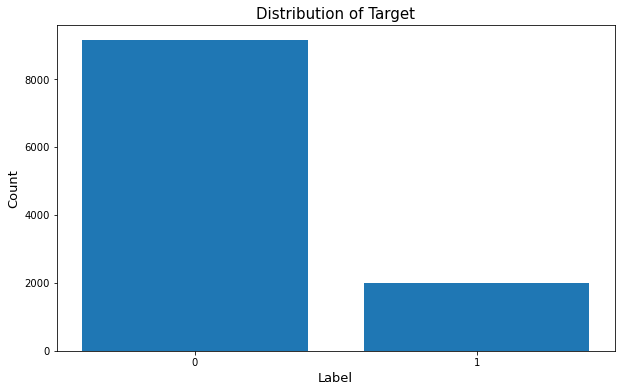

In [9]:
plt.figure(figsize = (10, 6))
plt.bar(['0', '1'], y['label'].value_counts().values)
plt.xlabel('Label', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Distribution of Target', fontsize = 15)

  + **Need to deal with imbalanced dataset.**

In [6]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y['label'].values)
print("Class weights should be: %f for 0 and %f for 1" % (class_weights[0], class_weights[1]))

Class weights should be: 2.780938 for 0 and 0.609604 for 1


Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [11]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

## Splitting Training and Test set

In [6]:
X['label']=y['label']
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
sensor_lst=list(X.iloc[:,-30:-1].columns)
X_wo_sensors = X.drop(sensor_lst, axis = 1)
repackaged_benign_test_X_wo_sensors = repackaged_benign_test_X.drop(sensor_lst, axis = 1)
covid_test_X_wo_sensors = covid_test_X.drop(sensor_lst, axis = 1)


In [7]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, X['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = X['label'])

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = train_test_split(X_wo_sensors, X_wo_sensors['label'], 
                                                                                            test_size = 0.2, 
                                                                                            random_state = 123, 
                                                                                            stratify = X_wo_sensors['label'])

In [21]:
X_test_wo_sensor

,Permission: FACTORY_TEST,Permission: DUMP,Permission: BATTERY_STATS,Permission: BIND_WALLPAPER,Permission: BIND_INPUT_METHOD,Permission: READ_LOGS,Permission: INSTALL_LOCATION_PROVIDER,Permission: READ_FRAME_BUFFER,Permission: SET_PROCESS_LIMIT,Permission: SET_ANIMATION_SCALE,...,Leak: Telephony_Services_Abuse,Leak: Code_Execution,Leak: Connection_Interfaces_Exfiltration,Leak: Audio_Video_Eavesdropping,Leak: Location_Lookup,Leak: Telephony_Identifiers_Leakage,Leak: Device_Settings_Harvesting,Leak: Suspicious_Connection_Establishment,isObfuscated,label
5927,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
5505,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,1,1
5249,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,1
9252,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,1
3160,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,0,0
6127,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,0,1,1
7364,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
6704,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,1,1


## resample training set

In [22]:
def resample(df):
    gp=df.groupby('label').count().iloc[:,0:1].reset_index().sort_values('label')
    gp.columns=['label','cnt']
    cnt_lst=list(gp['cnt'])
    x_df_resample=pd.concat([df.query('label==0').sample(n=cnt_lst[1]-cnt_lst[0],random_state=123,replace=True),df])
    y_df_resample=x_df_resample['label']
    return x_df_resample,y_df_resample

In [23]:
X_train_resample,y_train_resample=resample(X_train)
X_test_resample,y_test_resample=resample(X_test)

X_train_wo_sensor_resample,y_train_wo_sensor_resample=resample(X_train_wo_sensor)
X_test_wo_sensor_resample,y_test_wo_sensor_resample=resample(X_test_wo_sensor)

# Visualizing Dataset


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


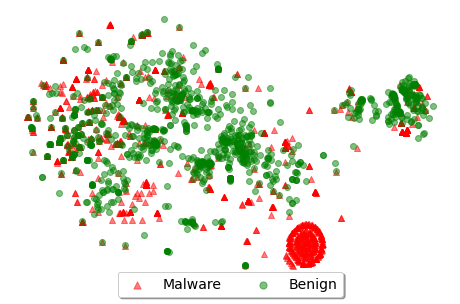

In [10]:
from sklearn.manifold import TSNE

combined_data = X.copy()
combined_data['Ground_Truth'] = y

# Separate malware and benign dataset to plot
df_malware = combined_data[combined_data['Ground_Truth'] == 1]
df_benign = combined_data[combined_data['Ground_Truth'] == 0]

# Drop the ground truth column
df_malware.drop(['Ground_Truth'], axis=1, inplace=True)
df_benign.drop(['Ground_Truth'], axis=1, inplace=True)

df_malware = pd.DataFrame(df_malware).sample(frac = 0.13, random_state=0)
m_rd_features = df_malware

df_benign = pd.DataFrame(df_benign).sample(frac = 0.5, random_state=0) 
b_rd_features = df_benign

X_embedded = TSNE(n_components=2, init='pca', random_state=0, perplexity=300).fit_transform(np.concatenate((m_rd_features,b_rd_features),axis=0))

plt.subplots(figsize=(8,5))
plt.axis('off')
plt.scatter(X_embedded[:m_rd_features.shape[0], 0], X_embedded[:m_rd_features.shape[0], 1], marker ='^', c='red',alpha=0.5)
plt.scatter(X_embedded[m_rd_features.shape[0]:, 0], X_embedded[m_rd_features.shape[0]:, 1], marker = 'o', c='green',alpha=0.5)
plt.legend(['Malware','Benign'], loc='upper center', bbox_to_anchor=(0.5, 0.05),
          fancybox=True, shadow=True, ncol=5, markerscale=1.2, 
          fontsize=14)
#plt.savefig("safe_learning.png")
plt.show()

# Neural Network

In [10]:
import tensorflow as tf
from tensorflow import keras
import IPython

In [19]:
# !conda install -c conda-forge keras-tuner

In [11]:
import kerastuner as kt

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy as logloss
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from keras.optimizers import adam


Using TensorFlow backend.


In [13]:
## keras-tunner--- cannot add dropout layer ---- not useful enough
def model_builder(hp):
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-64
    hp_units1 = hp.Int('units1', min_value = 16, max_value = 64, step = 16)
    model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
    model.add(keras.layers.Dropout(0.4))
    hp_units2 = hp.Int('units2', min_value = 16, max_value = 64, step = 16)
    model.add(keras.layers.Dense(units = hp_units2, activation = 'relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1,1e-2, 1e-3, 1e-4]) 
#     model.compile(loss='binary_crossentropy', optimizer=adam(lr=1e-4, decay=1e-6), metrics=[tf.keras.metrics.AUC(),'accuracy'])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(from_logits = True), 
                metrics=[tf.keras.metrics.Precision()])
    return model


In [14]:
tf.keras.backend.clear_session()
## keras tuner to tune the parameters, and object to maximize is val_precision
tuner = kt.Hyperband(model_builder,
                     kt.Objective("val_precision", direction="max"),
                     max_epochs = 10,
                     factor = 3,
                     directory = 'dnn_model_training',
                     project_name = '2_layers',
                     overwrite = True)   

# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='dnn_model_training',
#     project_name='2_layers',
#     overwrite = True) 

In [17]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [18]:
tuner.search(X_train_resample.drop('label',axis=1).values, y_train_resample.values, epochs = 20, 
             validation_data=(X_test.drop('label',axis=1).values, y_test.values),verbose=2,
             callbacks = [ClearTrainingOutput()])

KeyboardInterrupt: 

In [53]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. \n
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')} \n
The optimal number of units in the second densely-connected layer is {best_hps.get('units2')} \n
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is 32 

The optimal number of units in the second densely-connected layer is 32 

The optimal learning rate for the optimizer
is 0.0001.



In [ ]:
tf.keras.backend.clear_session()
tuner = kt.Hyperband(model_builder,
                     kt.Objective("val_precision", direction="max"),
                     max_epochs = 10,
                     factor = 3,
                     directory = 'dnn_model_training',
                     project_name = '2_layers_wo_sensor',
                     overwrite = True)   

# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='dnn_model_training',
#     project_name='2_layers',
#     overwrite = True) 

tuner.search(X_train_wo_sensor_resample.drop('label',axis=1).values,y_train_wo_sensor_resample.values, verbose=2,
             epochs = 20, validation_split=0.2,
             callbacks = [ClearTrainingOutput()])

In [40]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. \n
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')} \n
The optimal number of units in the second densely-connected layer is {best_hps.get('units2')} \n
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is 32 

The optimal number of units in the second densely-connected layer is 48 

The optimal learning rate for the optimizer
is 0.0001.



### bayesian optimizer

In [41]:
seed = 112 # Random seed
def dnn_with_sensor(dropout1,dropout2,neural1,neural2,learning_rate):
    from sklearn.metrics import roc_auc_score,f1_score
    import numpy as np
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = neural1, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout1))
    model.add(keras.layers.Dense(units = neural2, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                loss = keras.losses.BinaryCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
    
    model.fit(X_train_resample.drop('label',axis=1).values, y_train_resample.values, epochs = 20, verbose=False)
    y_pred=model.predict(X_test.drop('label',axis=1).values)
    val1_roc = f1_score(y_test,np.round(y_pred))
    return val1_roc

In [42]:
seed = 112 # Random seed
def dnn_wo_sensor(dropout1,dropout2,neural1,neural2,learning_rate):
    from sklearn.metrics import roc_auc_score,f1_score
    import numpy as np
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = neural1, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout1))
    model.add(keras.layers.Dense(units = neural2, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                loss = keras.losses.BinaryCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
    
    model.fit(X_train_wo_sensor_resample.drop('label',axis=1).values,
              y_train_wo_sensor_resample.values, epochs = 20, verbose=False)
    
    y_pred=model.predict(X_test_wo_sensor.drop('label',axis=1).values)
    val1_roc = f1_score(y_test,np.round(y_pred))
    return val1_roc

In [20]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

gp_params = {"alpha": 1e-10}

seed = 112 # Random seed

hyperparameter_space = {
    'dropout1': (0.4, 0.5),
    'dropout2': (0.4, 0.5),
    'neural1':(16,64),
    'neural2':(16,64),
    'learning_rate': (0.001,0.001),
}

dnnBO = BayesianOptimization(f = dnn_with_sensor, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

dnnBO.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)


|   iter    |  target   | dropout1  | dropout2  | learni... |  neural1  |  neural2  |
-------------------------------------------------------------------------------------
|  1        |  0.8393   |  0.4375   |  0.464    |  0.001    |  19.63    |  53.29    |
|  2        |  0.8509   |  0.4833   |  0.4055   |  0.001    |  58.5     |  50.67    |
|  3        |  0.8407   |  0.4003   |  0.4981   |  0.001    |  20.55    |  34.94    |
|  4        |  0.8538   |  0.4983   |  0.493    |  0.001    |  63.96    |  30.73    |
|  5        |  0.8536   |  0.4015   |  0.4748   |  0.001    |  63.05    |  31.63    |
|  6        |  0.8428   |  0.4989   |  0.453    |  0.001    |  63.62    |  16.02    |
|  7        |  0.8456   |  0.422    |  0.4359   |  0.001    |  63.48    |  63.99    |
|  8        |  0.8513   |  0.4491   |  0.4724   |  0.001    |  46.77    |  40.85    |
|  9        |  0.8522   |  0.4167   |  0.4016   |  0.001    |  43.91    |  60.3     |
|  10       |  0.8373   |  0.4613   |  0.4655   |  0.0

In [32]:
# X_train.shape[1]

### model training

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.callbacks import ModelCheckpoint
# from keras.losses import categorical_crossentropy as logloss
# # from tensorflow.keras.utils import np_utils
# from keras.layers import Dropout
# from keras.optimizers import adam
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Activation

In [49]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model = Sequential()
model.add(Dense(48, input_dim=X_train.shape[1]-1, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
# model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt=keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                16944     
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 17,745
Trainable params: 17,745
Non-trainable params: 0
_________________________________________________________________


In [50]:
history=model.fit(X_train_resample.drop('label',axis=1).values, y_train_resample.values,
                  validation_data=(X_test.drop('label',axis=1).values, y_test.values),verbose=2,
                  epochs=50,batch_size=32)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50,batch_size=32, shuffle=True)

Train on 14626 samples, validate on 2230 samples
Epoch 1/50
14626/14626 - 3s - loss: 0.6490 - accuracy: 0.6023 - auc: 0.6601 - val_loss: 0.5556 - val_accuracy: 0.7816 - val_auc: 0.8315
Epoch 2/50
14626/14626 - 2s - loss: 0.5640 - accuracy: 0.7043 - auc: 0.7881 - val_loss: 0.5195 - val_accuracy: 0.7556 - val_auc: 0.8448
Epoch 3/50
14626/14626 - 2s - loss: 0.5182 - accuracy: 0.7410 - auc: 0.8263 - val_loss: 0.4738 - val_accuracy: 0.7704 - val_auc: 0.8613
Epoch 4/50
14626/14626 - 2s - loss: 0.4823 - accuracy: 0.7691 - auc: 0.8534 - val_loss: 0.4448 - val_accuracy: 0.7843 - val_auc: 0.8695
Epoch 5/50
14626/14626 - 2s - loss: 0.4615 - accuracy: 0.7768 - auc: 0.8647 - val_loss: 0.4287 - val_accuracy: 0.7816 - val_auc: 0.8769
Epoch 6/50
14626/14626 - 2s - loss: 0.4422 - accuracy: 0.7955 - auc: 0.8785 - val_loss: 0.4160 - val_accuracy: 0.7964 - val_auc: 0.8832
Epoch 7/50
14626/14626 - 2s - loss: 0.4274 - accuracy: 0.8035 - auc: 0.8868 - val_loss: 0.3919 - val_accuracy: 0.8067 - val_auc: 0.8875

In [51]:
# Plot Accuracy
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plot Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plot Loss
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model auc')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

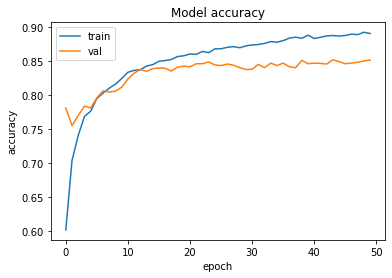

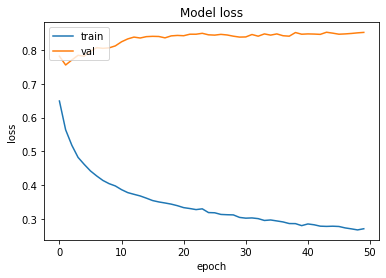

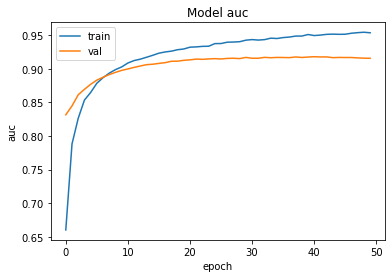

In [52]:
plot(history)

In [59]:
## predict using sensor model
y_pred_with_sensor = model.predict(X_test.drop('label',axis=1).values)
y_pred_repack_benign = model.predict_proba(repackaged_benign_test_X)
covid_test_X.fillna(0, inplace = True)
covid_y_pred_w_sensor = model.predict_proba(covid_test_X)

## model without sensor

In [34]:
tf.keras.backend.clear_session()
model_wo = tf.keras.Sequential()
model_wo = Sequential()
model_wo.add(Dense(32, input_dim=X_train_wo_sensor_resample.shape[1]-1, activation='relu'))
model_wo.add(Dropout(0.4))
model_wo.add(Dense(48, activation='relu'))
model_wo.add(Dropout(0.4))
# model.add(Dense(128, activation='relu'))
model_wo.add(Dense(1, activation='sigmoid'))

# Compile model
opt=keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model_wo.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',tf.keras.metrics.AUC()])
model_wo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                10368     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 12,001
Trainable params: 12,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_wo=model_wo.fit(X_train_wo_sensor_resample.drop('label',axis=1).values, y_train_wo_sensor_resample.values,
                  validation_data=(X_test_wo_sensor.drop('label',axis=1).values, y_test_wo_sensor.values),
                  epochs=50,batch_size=32,verbose=2)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50,batch_size=32, shuffle=True)

Train on 14626 samples, validate on 2230 samples
Epoch 1/50
14626/14626 - 3s - loss: 0.6807 - accuracy: 0.5649 - auc: 0.6363 - val_loss: 0.6737 - val_accuracy: 0.6341 - val_auc: 0.8102
Epoch 2/50
14626/14626 - 2s - loss: 0.6050 - accuracy: 0.7016 - auc: 0.7863 - val_loss: 0.5686 - val_accuracy: 0.7879 - val_auc: 0.8373
Epoch 3/50
14626/14626 - 2s - loss: 0.5323 - accuracy: 0.7563 - auc: 0.8313 - val_loss: 0.4794 - val_accuracy: 0.8094 - val_auc: 0.8528
Epoch 4/50
14626/14626 - 2s - loss: 0.4883 - accuracy: 0.7759 - auc: 0.8537 - val_loss: 0.4618 - val_accuracy: 0.8040 - val_auc: 0.8613
Epoch 5/50
14626/14626 - 2s - loss: 0.4643 - accuracy: 0.7885 - auc: 0.8678 - val_loss: 0.4333 - val_accuracy: 0.8094 - val_auc: 0.8700
Epoch 6/50
14626/14626 - 2s - loss: 0.4421 - accuracy: 0.7958 - auc: 0.8806 - val_loss: 0.4133 - val_accuracy: 0.8256 - val_auc: 0.8760
Epoch 7/50
14626/14626 - 2s - loss: 0.4273 - accuracy: 0.8074 - auc: 0.8882 - val_loss: 0.4032 - val_accuracy: 0.8274 - val_auc: 0.8808

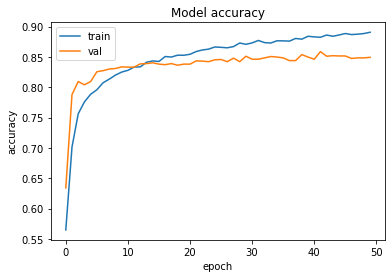

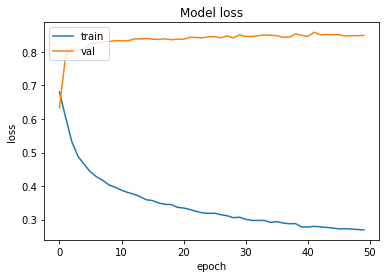

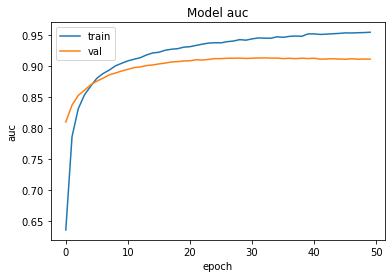

In [37]:
plot(history_wo)

In [38]:
y_pred_wo_sensor = model_wo.predict(X_test_wo_sensor.drop('label',axis=1).values)
y_pred_repack_benign_wo_sensor = model_wo.predict_proba(repackaged_benign_test_X_wo_sensors)
covid_y_pred_wo_sensor = model_wo.predict_proba(covid_test_X_wo_sensors)

## TESTING

In [79]:
tp_0=(np.array([1]*y_pred_wo_sensor.shape[0])-y_pred_wo_sensor[:,0]).reshape(-1,1)
prob_wo=np.stack([tp_0[:,0],y_pred_wo_sensor[:,0]],axis=1)

In [83]:
prob

array([[0.02708215, 0.97291785],
       [0.25398922, 0.74601078],
       [0.051759  , 0.948241  ],
       ...,
       [0.00475156, 0.99524844],
       [0.00199729, 0.99800271],
       [0.05256152, 0.94743848]])

In [82]:
with open('../../dnn_pred_with_sensor.npy', 'wb') as f:
    np.save(f, prob)
with open('../../dnn_pred_wo_sensor.npy', 'wb') as f:
    np.save(f, prob_wo)

AUC (including sensor features) 0.9166020160097296
AUC (not including sensor features) 0.9118074142146002


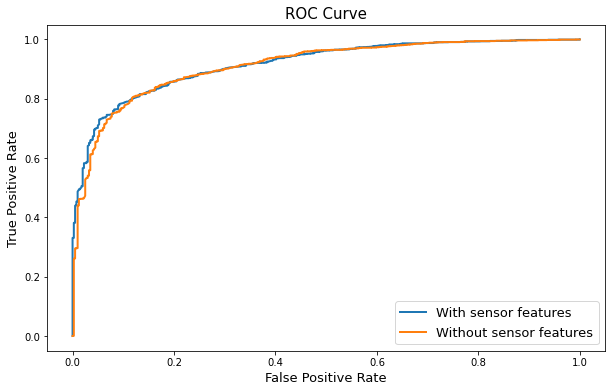

In [60]:
plt.figure(figsize = (10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_with_sensor)
fpr2, tpr2, _2 = roc_curve(y_test_wo_sensor, y_pred_wo_sensor)
plt.plot(fpr, tpr, lw=2, label='With sensor features')
plt.plot(fpr2, tpr2, lw=2, label='Without sensor features')
print('AUC (including sensor features)', roc_auc_score(y_test, y_pred_with_sensor))
print('AUC (not including sensor features)', roc_auc_score(y_test, y_pred_wo_sensor))

plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title('ROC Curve', fontsize = 15)
plt.legend(fontsize = 13)

In [59]:
with open('../../dnn_pred_with_sensor.npy', 'wb') as f:
    np.save(f, fpr)
    np.save(f,  tpr)
with open('../../dnn_pred_wo_sensor.npy', 'wb') as f:
    np.save(f, fpr2)
    np.save(f,  tpr2)

In [85]:
precision_recall_fscore_support(y_test, np.round(y_pred_with_sensor))

(array([0.56466302, 0.94586556]),
 array([0.77306733, 0.8693275 ]),
 array([0.65263158, 0.90598291]),
 array([ 401, 1829]))

In [84]:
precision_recall_fscore_support(y_test, np.round(y_pred_wo_sensor))

(array([0.55632582, 0.95160315]),
 array([0.80049875, 0.8600328 ]),
 array([0.65644172, 0.90350373]),
 array([ 401, 1829]))

## Other Metrics

In [62]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(y_test, np.round(y_pred_with_sensor)))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(y_test, np.round(y_pred_wo_sensor)))

Balanced Average Accuracy (including sensor features): 0.8337664586483491
Balanced Average Accuracy (not including sensor features): 0.8132027776376445


## Paired or Non-paired

In [88]:
pairs = pd.read_csv('../../repackaging_pairs.txt')
# Train test split
X_ = pd.read_csv('../data/Training_Data/Training_Dataset.csv')
y_ = pd.read_csv('../data/Training_Data/Labels.csv')

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,y_['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y_['label'])

In [89]:
paired_w_sensor_accuracy = []
non_paired_w_sensor_accuracy = []
paired_wo_sensor_accuracy = []
non_paired_wo_sensor_accuracy = []

visited = []
for i in range(X_test_.shape[0]):
    acc1 = np.round(y_pred_with_sensor[i])  == y_test_.iloc[i]
    acc2 =np.round(y_pred_wo_sensor[i]) == y_test_.iloc[i]
    
    sha = X_test_.iloc[i]['SHA256']
    
    for idx in pairs.index:
        if sha == pairs.loc[idx, 'SHA256_ORIGINAL']:
            if pairs.loc[idx, 'SHA256_REPACKAGE'] in X_test_['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)
                non_paired_wo_sensor_accuracy.append(acc2)
            break
        elif sha == pairs.loc[idx, 'SHA256_REPACKAGE']:
            if pairs.loc[idx, 'SHA256_ORIGINAL'] in X_test_['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)  
                non_paired_wo_sensor_accuracy.append(acc2)  
            break

In [90]:
acc_1 = []
acc_2 = []
for i in range(X_test.shape[0]):
    acc1 = np.round(y_pred_with_sensor[i]) == y_test.iloc[i]
    acc2 = np.round(y_pred_wo_sensor[i])== y_test.iloc[i]
    
    acc_1.append(acc1)
    acc_2.append(acc2)

In [91]:
np.sum(acc_1)
np.sum(paired_w_sensor_accuracy)
np.sum(non_paired_w_sensor_accuracy)

1712

In [86]:
# print("Accuracy for paired apps (including sensor features):", np.sum(paired_w_sensor_accuracy)/len(paired_w_sensor_accuracy))
# print("Accuracy for non-paired apps (including sensor features):", np.sum(non_paired_w_sensor_accuracy)/len(non_paired_w_sensor_accuracy))

# print("Accuracy for paired apps (not including sensor features):", np.sum(paired_wo_sensor_accuracy)/len(paired_wo_sensor_accuracy))
# print("Accuracy for non-paired apps (not including sensor features):", np.sum(non_paired_wo_sensor_accuracy)/len(non_paired_wo_sensor_accuracy))

In [92]:
print("Accuracy for paired apps (including sensor features):", np.sum(paired_w_sensor_accuracy)/len(paired_w_sensor_accuracy))
print("Accuracy for non-paired apps (including sensor features):", np.sum(non_paired_w_sensor_accuracy)/len(non_paired_w_sensor_accuracy))

print("Accuracy for paired apps (not including sensor features):", np.sum(paired_wo_sensor_accuracy)/len(paired_wo_sensor_accuracy))
print("Accuracy for non-paired apps (not including sensor features):", np.sum(non_paired_wo_sensor_accuracy)/len(non_paired_wo_sensor_accuracy))

Accuracy for paired apps (including sensor features): 0.8281938325991189
Accuracy for non-paired apps (including sensor features): 0.854717923115327
Accuracy for paired apps (not including sensor features): 0.788546255506608
Accuracy for non-paired apps (not including sensor features): 0.8562156764852721


## Testing on Repackaged Benign Apps Dataset

In [59]:
# accuracy = accuracy_score.score(repackaged_benign_test_X, repackaged_benign_test_y['label'].values)
# print('Accuracy (including sensor features):', accuracy)

In [93]:
# y_pred_repack_benign = pipe_with_sensor.predict_proba(repackaged_benign_test_X)
# y_pred_repack_benign_wo_sensor = pipe_without_sensor.predict_proba(repackaged_benign_test_X_wo_sensors)
accuracy = accuracy_score(repackaged_benign_test_y['label'],np.round(y_pred_repack_benign))
print('Accuracy (including sensor features):', accuracy)
accuracy = accuracy_score(repackaged_benign_test_y['label'],np.round(y_pred_repack_benign_wo_sensor))
print('Accuracy (without sensor features):', accuracy)

Accuracy (including sensor features): 0.9009797060881736
Accuracy (without sensor features): 0.9552134359692093


## Testing on covid-19

In [94]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, np.round(covid_y_pred_w_sensor)))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, np.round(covid_y_pred_wo_sensor)))

Balanced Average Accuracy (including sensor features): 0.5197907188353048
Balanced Average Accuracy (not including sensor features): 0.4840764331210191


## Thumbprint Score

In [95]:
X_test_['y_pred_with_sensor'] = np.round(y_pred_with_sensor)
X_test_['y_pred_wo_sensor'] = np.round(y_pred_wo_sensor)
X_test_['label'] = y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
# scores of top 10 authors
X_test_['correct'] = X_test_['label'] == X_test_['y_pred_with_sensor']
summ = X_test_[X_test_['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                              correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:].reset_index()
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ThumbPrint,N,correct,score
0,61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,102,0.629630
1,28EAC321D548B4247D9C84810C0656EC9426716B,97,82,0.845361
2,F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71,1.000000
3,95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67,1.000000
4,00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58,1.000000
5,F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41,0.788462
6,45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45,1.000000
7,6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44,1.000000
8,699512C8B49E7A01A622BD250544E09A80A42D55,39,32,0.820513
9,5BFC55F389F4B5427341E4320A501711140AE444,35,21,0.600000


In [97]:
# scores of top 10 authors
X_test_['correct'] = X_test_['label'] == X_test_['y_pred_wo_sensor']
summ = X_test_[X_test_['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:].reset_index()
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ThumbPrint,N,correct,score
0,61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,101,0.623457
1,28EAC321D548B4247D9C84810C0656EC9426716B,97,78,0.804124
2,F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71,1.000000
3,95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67,1.000000
4,00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58,1.000000
5,F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41,0.788462
6,45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45,1.000000
7,6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44,1.000000
8,699512C8B49E7A01A622BD250544E09A80A42D55,39,29,0.743590
9,5BFC55F389F4B5427341E4320A501711140AE444,35,19,0.542857


# SHAP FOR MISCLASSIFICATION

In [49]:
def compute_changes(row):
    if row['feature_importance_vals_true']*row['feature_importance_vals_false']<0:
        return 1
    else:
        return 0

class SHAP_Visual_ThumbPrint:  ## use shap to explain the prediction results of a thumbprint for a certain model
    def __init__(self,thumbprint,X_train,X_test,model,model_name,feature_lst,link='logit'):
        '''
        thumbprint: the thumbprint of one author
        X_test: from which dataframe to get the author information
        model_with_sensor: the model trained using sensor information
        model_wo_sensor: the model trained without sensor information
        '''
        self.thumbprint = thumbprint
        self.model = model
        self.model_name=model_name         ## model_name is related to the type of shap explainer
        self.X_train=X_train               ## useful for linear_explainer and dnn_explainer because this provides background distribution of training set
        self.X_test=X_test                ## useful only for get_prediction_records of a certain type (eg:correct classifications, misclassifications)
        
        self.get_pred_record(thumbprint,feature_lst) ## init author dataframes
        self.init_explainer() ## init explainer
        self.feature_lst=feature_lst
        
        
    def combine_feature_importance_all(self):  ## combine the feature importance of misclsfy and clsfy
        feature_importance_correct=self.compute_feature_importance(self.author_true_df)
        feature_importance_false=self.compute_feature_importance(self.author_false_df)
        feature_importance_merge=feature_importance_correct.merge(feature_importance_false,how='inner',on='col_name')
        return feature_importance_merge
        
    def get_pred_record(self,thumbprint,feature_lst): ## just filter author dataframe for shap_value computations
        author=self.X_test.query(f'ThumbPrint=="{thumbprint}"').query('label==1')
#         print(author.groupby('correct').agg(cnt=('SHA256','count')).reset_index())
        author_true=author.query('correct==1')
        author_false=author.query('correct==0')
#         return author[feature_lst],author_true[feature_lst],author_false[feature_lst]
        self.author_df=author[feature_lst]              ## features of apps of an author (thumbprint)
        self.author_true_df=author_true[feature_lst]    ## features of all correct classifications of an author (thumbprint)
        self.author_false_df=author_false[feature_lst]  ## features of all misclassifications of an author (thumbprint)
        
        
    def init_explainer(self):
        ## useful link about shap models:
        ## https://shap.readthedocs.io/en/latest/examples.html#linear-explainer-examples
        if self.model_name.lower() in {'xgboost','xgb'}:
            self.explainer= shap.TreeExplainer(self.model)
        elif self.model_name.lower() in {'logistic_regression','LR','logistic regression'}:
            self.explainer=shap.LinearExplainer(self.model,self.X_train)
            ## The background dataset to use for computing conditional expectations. 
            ## Note that only the mean and covariance of the dataset are used. 
            ## This means passing a raw data matrix is just a convienent alternative to passing the mean and covariance directly.
        elif self.model_name.lower() in {'dnn'}: ## useful for both keras model (framework ='pytorch') and pytorch model (framework ='pytorch')
            background = self.X_train.values[np.random.choice(self.X_train.values.shape[0], 1000, replace=False)]
            self.explainer=shap.DeepExplainer(self.model,background)
            
            ## why select 100 or 1000 from x_train:
            ## The background dataset to use for integrating out features. 
            ## Deep integrates over these samples. 
            ## The data passed here must match the input tensors given in the first argument(model). 
            ## Note that since these samples are integrated over for each sample 
            ## you should only something like 100 or 1000 random background samples, not the whole training dataset.
        else:
            self.explainer=shap.KernelExplainer(self.model,self.X_train,link='logit')
            ## A generalized linear model link to connect the feature importance values to the model output. 
            ## Since the feature importance values, phi, sum up to the model output, 
            ## it often makes sense to connect them to the output with a link function where link(output) = sum(phi). 
            ## If the model output is a probability then the LogitLink link function makes the feature importance values have log-odds units.
            
    def compute_feature_importance(self,df): ## compute feature_importance for a dataframe
        shap_values = self.explainer.shap_values(df)
        vals= np.abs(shap_values).mean(0)
        feature_importance = pd.DataFrame(list(zip(df.columns,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        feature_importance['rank']=list(range(1,feature_importance.shape[0]+1))
        feature_importance['ThumbPrint']=self.thumbprint
        
        return feature_importance

    def combine_feature_importance_all(self):  ## combine the feature importance of misclsfy and clsfy
        feature_importance_correct=self.compute_feature_importance(self.author_true_df[self.feature_lst])
        feature_importance_false=self.compute_feature_importance(self.author_false_df[self.feature_lst])
        feature_importance_merge=feature_importance_correct.merge(feature_importance_false,how='inner',on=['col_name','ThumbPrint'],suffixes=['_true','_false'])
        feature_importance_merge['importance_change']=feature_importance_merge['feature_importance_vals_true']-feature_importance_merge['feature_importance_vals_false'] 
        feature_importance_merge['rank_change']=feature_importance_merge['rank_true']-feature_importance_merge['rank_false']
        feature_importance_merge['change_direction']=feature_importance_merge.apply(lambda x:compute_changes(x),axis=1)
        return feature_importance_merge 
    
    def summary_plot(self,df):
        '''
        plot shows, how much features push the output value towards negativity or positivity
        and color the visual output by the feature values (high or low, in our case : 0 or 1 )
        '''
        shap_values = self.explainer.shap_values(df)
        shap.summary_plot(shap_values, df)
        
    def force_plot(self,df):   ## cannot be used in function?
        '''
        plot how much features push the output (can be used for an example or some examples(mean))
        '''
        print(self.explainer.expected_value)
        shap_values = self.explainer.shap_values(df)
        shap.force_plot(self.explainer.expected_value, shap_values, df)
        
    def dependence_plot(self,df,feature_name):  
        '''
        this plot is mainly use to explore the dependency between different features, temporaly not useful here
        '''
        shap_values = explainer.shap_values(df)
        shap.dependence_plot(feature_name, shap_values, df)
    
    def visual_thumbprint(self):   ## just to show how to use visualization functions
        feature_importance=self.combine_feature_importance_all() ## compute shap value for correect classified and misclassified
        self.summary_plot(self.author_true_df)
        self.summary_plot(self.author_false_df)
        
        self.force_plot(self.author_true_df.iloc[0,:])
        self.force_plot(self.author_false_df.iloc[0,:])
        
def force_plot(shap_explainer,df):
    shap_values = shap_explainer.explainer.shap_values(df)
    print(shap_values.shape)
    shap.force_plot(shap_tb.explainer.expected_value, shap_values, df)

'2.0.0'

In [50]:
def combine_top_thumbprint(X_train,X_test,model,model_name,feature_lst):
    '''
    X_train: the data used for training the model (with sensor or without sensor)
    X_test: the data used as testing data
    model: the model trained (only model cannot use pipeline)
    model_name: xgboost --------------- {'xgboost','xgb'}
                logistic_regression --- {'logistic_regression','LR','logistic regression'}
                dnn ------------------- {'dnn'}
                svm & knn ------------- {'others'}
    '''
    # scores of top 10 authors
    X_test['correct'] = X_test_['label'] == X_test['y_pred_with_sensor']
    summ = X_test_[X_test_['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                                  correct=('correct','sum'))\
    .sort_values(['N','correct'], ascending=False).iloc[:10,:].reset_index()
    summ['score'] = summ['correct']/summ['N']
    
    feature_importance_df=pd.DataFrame()
    for idx,row in summ.iterrows():
        thumbprint=row['ThumbPrint']
        if row['score']==1:
            continue
        shap_tb=SHAP_Visual_ThumbPrint(thumbprint,X_train,X_test,model,model_name,feature_lst)
        feature_importance=shap_tb.combine_feature_importance_all()
        feature_importance=feature_importance[feature_importance.importance_change!=0]
        feature_importance_df=pd.concat([feature_importance_df,feature_importance],axis=0)
    summ_=summ.merge(feature_importance_df,on='ThumbPrint')
    return summ,summ_

In [80]:
summ,summ_combine=combine_top_thumbprint(X_train_resample.drop('label',axis=1),X_test_,model,'dnn',
                                                  list(repackaged_benign_test_X.columns))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: in converted code:
    relative to /Users/songsong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages:

    shap/explainers/_deep/deep_tf.py:239 grad_graph  *
        out = self.model(shap_rAnD)
    tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    tensorflow_core/python/keras/engine/sequential.py:256 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    tensorflow_core/python/keras/engine/network.py:708 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    tensorflow_core/python/keras/engine/network.py:860 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    tensorflow_core/python/keras/engine/base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    tensorflow_core/python/keras/layers/core.py:1056 call
        outputs = gen_math_ops.mat_mul(inputs, self.kernel)
    tensorflow_core/python/ops/gen_math_ops.py:6136 mat_mul
        name=name)
    tensorflow_core/python/framework/op_def_library.py:536 _apply_op_helper
        repr(values), type(values).__name__, err))

    TypeError: Expected float32 passed to parameter 'b' of op 'MatMul', got <tf.Variable 'dense/kernel:0' shape=(352, 32) dtype=float32> of type 'ResourceVariable' instead. Error: custom_record_gradient() takes 4 positional arguments but 5 were given
